In [1]:
import numpy as np
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u
import gc
from numba import njit, prange
from concurrent.futures import ProcessPoolExecutor

In [2]:
%matplotlib inline

In [3]:
data_shape = np.load('Data/HIP13402/shape.npy')

data = np.memmap('Data/HIP13402/seperated_raw_data.npy', dtype='float32', mode='r', shape=data_shape)

In [4]:
print(data[0])

[[[2.9737974e+08 3.2028000e+08 3.0362010e+08 ... 2.9946086e+08
   3.2718822e+08 2.7946435e+08]
  [2.5460648e+08 2.8272547e+08 2.9888973e+08 ... 2.6859581e+08
   2.8414214e+08 2.7613376e+08]
  [3.0044432e+08 2.2307587e+08 2.5267971e+08 ... 2.6419120e+08
   2.7568602e+08 2.8964707e+08]
  ...
  [3.3266995e+08 2.8726912e+08 2.7200928e+08 ... 3.4899283e+08
   3.0554701e+08 2.7303907e+08]
  [2.6879920e+08 2.8195101e+08 2.9565376e+08 ... 2.8785136e+08
   2.8035069e+08 2.8888800e+08]
  [2.8728621e+08 2.8424013e+08 2.8181562e+08 ... 2.9164854e+08
   2.6896890e+08 3.6296074e+08]]

 [[2.9248528e+08 2.7308544e+08 3.0395229e+08 ... 2.6141981e+08
   3.1028470e+08 2.5517131e+08]
  [2.8441613e+08 2.8950326e+08 2.5309843e+08 ... 2.9618851e+08
   2.8762019e+08 2.5206470e+08]
  [2.4620242e+08 2.9434819e+08 3.0132909e+08 ... 2.8049344e+08
   2.8623357e+08 3.0429315e+08]
  ...
  [2.8814358e+08 2.4986566e+08 2.8908390e+08 ... 3.0320621e+08
   3.2463923e+08 2.6274678e+08]
  [3.0033613e+08 2.8985936e+08 2.999

In [5]:
test_data = data[0:10000]

In [6]:
test_data[0].shape

(6, 16, 4096)

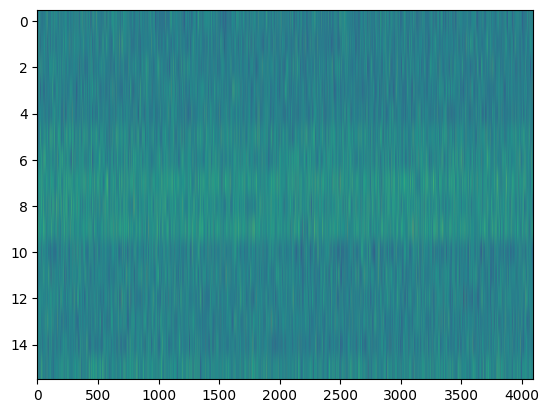

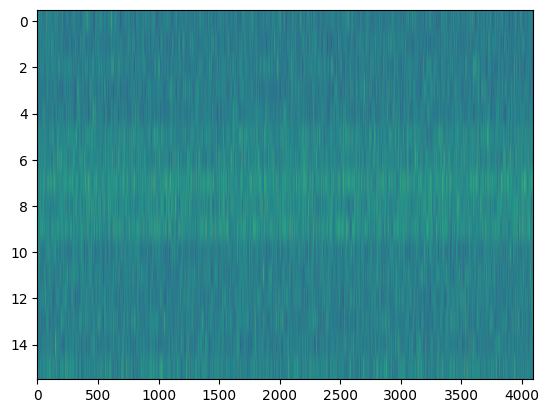

In [7]:
plt.imshow(test_data[0,0],aspect= 'auto')
plt.show()

plt.imshow(test_data[1,0],aspect= 'auto')
plt.show()

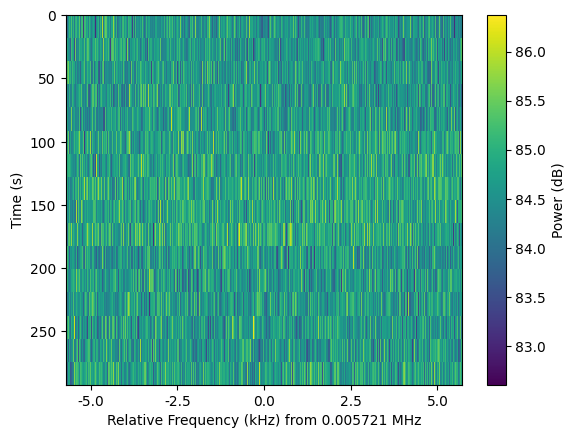

In [8]:
frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                        dt=18.25361108*u.s,
                        fch1=0*u.MHz,
                        ascending = True,
                        data=test_data[0,0])

frame.plot()
plt.show()

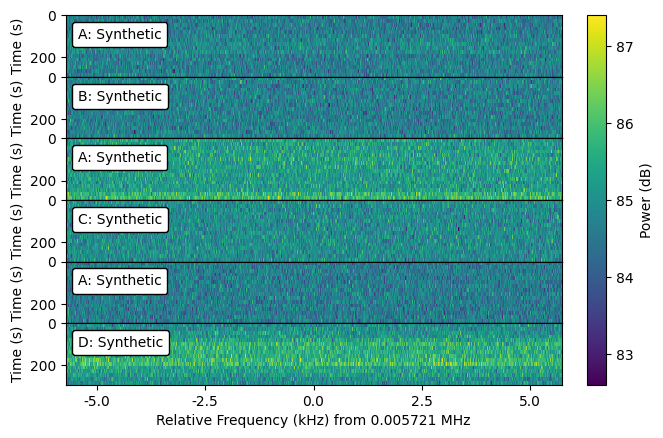

In [9]:
c = stg.Cadence()
frame_list = []
for i in range(6):
    frame = stg.Frame.from_data(df=2.7939677238464355*u.Hz,
                            dt=18.25361108*u.s,
                            fch1=0*u.MHz,
                            ascending = True,
                            data=test_data[0,i])
    frame_list.append(frame)
    # del frame
    # gc.collect()



c = stg.OrderedCadence(frame_list, order = "ABACAD")
c.plot()
plt.show()

(array([<Axes: ylabel='Time (s)'>, <Axes: >, <Axes: ylabel='Time (s)'>,
        <Axes: >, <Axes: ylabel='Time (s)'>, <Axes: >,
        <Axes: ylabel='Time (s)'>, <Axes: >, <Axes: ylabel='Time (s)'>,
        <Axes: >,
        <Axes: xlabel='Relative Frequency (kHz) from 0.005721 MHz', ylabel='Time (s)'>],
       dtype=object),
 <Axes: ylabel='Power (dB)'>)

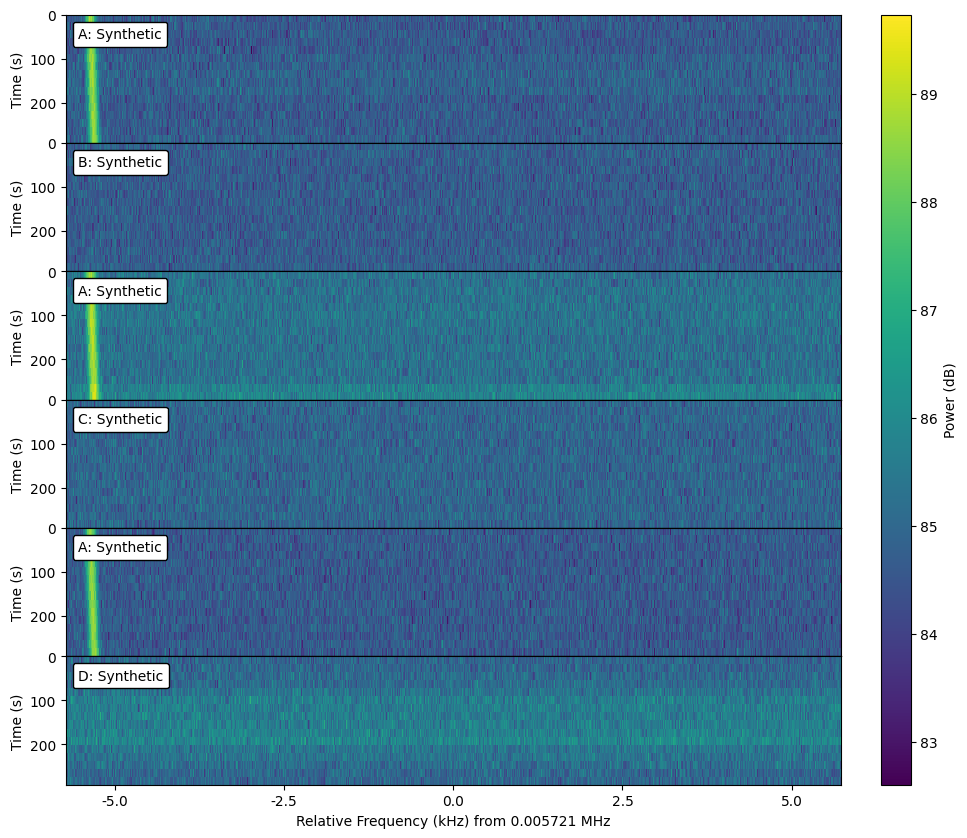

In [10]:
c.by_label("A").add_signal(stg.constant_path(f_start=c[0].get_frequency(index=128),
                               drift_rate=0.2*u.Hz/u.s),
                           stg.constant_t_profile(level=c[0].get_intensity(snr=60)),
                           stg.sinc2_f_profile(width=100*c[0].df*u.Hz),
                           stg.constant_bp_profile(level=1),
                           doppler_smearing=True)
fig = plt.figure(figsize=(10, 10))
c.plot()

In [11]:
def process_cadence(data_slice):
    """
    Process a single cadence of data and generate an OrderedCadence.

    Parameters:
    - data_slice: A 2D numpy array (n_frames, frame_data) for one cadence.

    Returns:
    - OrderedCadence object.
    """
    frame_list = []
    for j in range(data_slice.shape[0]):  # Loop over frames in the cadence
        frame = stg.Frame.from_data(
            df=2.7939677238464355 * u.Hz,
            dt=18.25361108 * u.s,
            fch1=0 * u.MHz,
            ascending=True,
            data=data_slice[j]
        )
        frame_list.append(frame)

    # Create an OrderedCadence for this set of frames
    return stg.OrderedCadence(frame_list, order="ABACAD")


In [12]:
def generate_frames(data, max_workers=4):
    """
    Generate frames and cadences in parallel using ProcessPoolExecutor.

    Parameters:
    - data: 3D numpy array with shape (n_cadences, n_frames, frame_data)
    - max_workers: Number of parallel processes to use.

    Returns:
    - List of OrderedCadence objects.
    """
    cadences = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        cadences = list(executor.map(process_cadence, data))

    return cadences

In [13]:
for i in np.round(np.linspace(1,32,8)):
    print(i)

1.0
5.0
10.0
14.0
19.0
23.0
28.0
32.0


In [14]:
import time 
times = []
test_times = [26, 24, 16, 8, 1]

print(test_times)
for i in test_times:
    start = time.time()
    cadences = generate_frames(test_data, max_workers=i)
    end = time.time()
    times.append(end-start)
    print(f"Time taken: {end - start:.2f} seconds")



[32, 24, 16, 8, 1]
Time taken: 29.22 seconds
Time taken: 34.83 seconds
Time taken: 45.49 seconds
Time taken: 52.40 seconds


In [ ]:
plt.plot(test_times, times)